# 0. Foreward

# 1. Preparation

## 1.1. Load Libraries & Settings

In [33]:
import pandas as pd
import numpy as np
import warnings
import torch
from torch import nn
from torch.nn import functional as F
import plotly.express as px
import pickle
import os
import gc
import re
import random
import lightgbm as lgb
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as tts

warnings.simplefilter("ignore")
pd.options.display.max_columns=100
pd.options.display.max_rows=100
torch.autograd.set_detect_anomaly(True)

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

device = "cuda" if torch.cuda.is_available() else "cpu"
%env TOKENIZERS_PARALLELISM=true
%env CUDA_LAUNCH_BLOCKING=1

env: TOKENIZERS_PARALLELISM=true
env: CUDA_LAUNCH_BLOCKING=1


In [34]:
class CFG:
    INPUT = "../data/"
    MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"#"sbert-models/paraphrase-multilingual-mpnet-base-v2"
    MAX_LEN = 512
    BATCH_SIZE = 2**7
    EPOCHS = 50
    THRESHOLD = .5
    EARLY_STOPPING_ROUNDS = 5

## 1.2. Fetching & Preprocessing Data

### 1.2.1. Fetching CSVs & LabelEncoding

In [43]:
%%time

content = pd.read_csv(f'{CFG.INPUT}/content.csv')
correlations = pd.read_csv(f'{CFG.INPUT}/correlations.csv')
topics = pd.read_csv(f'{CFG.INPUT}/topics.csv')
sample_submission = pd.read_csv(f'{CFG.INPUT}/sample_submission.csv')

t_le = LabelEncoder()
topics_all = list(set(correlations.topic_id) | set(topics.id) | set(topics.parent)) + ["None"]
t_le.fit(topics_all)
topics.id = t_le.transform(topics.id)
topics.parent = t_le.transform(topics.parent.fillna("None"))
correlations.topic_id = t_le.transform(correlations.topic_id)

c_le = LabelEncoder()
content.id = c_le.fit_transform(content.id)

target_topics = sample_submission.topic_id
target_topics_enc = t_le.transform(target_topics)

del topics_all
gc.collect()

display(content.head())
display(correlations.head())
display(topics.head())
display(sample_submission.head())

,id,title,description,kind,text,language,copyright_holder,license
0,0,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,1,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,2,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,3,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,4,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


,topic_id,content_ids
0,2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,5,c_11a1dc0bfb99
3,6,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,7,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


,id,title,description,channel,category,level,language,parent,has_content
0,2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,6807,True
1,3,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,50876,False
2,4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,62630,True
3,5,Transcripts,NaN,6e3ba4,source,3,en,19138,True
4,6,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,67917,True


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


CPU times: user 6.38 s, sys: 580 ms, total: 6.95 s
Wall time: 6.95 s


### 1.2.2. Preprocessing Tables

In [44]:
%%time

"""
correlations
"""
correlations_transform = []
for i, row in correlations.iterrows():
    for c in row.content_ids.split(" "):
        correlations_transform.append((row.topic_id, c))

correlations_transform = pd.DataFrame(
    correlations_transform, columns=["topic_id", "content_id"]
)
correlations_transform.content_id = c_le.transform(correlations_transform.content_id)

correlations_transform = pd.merge(
    correlations_transform,
    content[["id", "kind", "language", "copyright_holder", "license"]].rename(
        columns={col:"c_"+col if col != "id" else "content_id" for col in content.columns}
    ),
    how="left",
    on="content_id",
)

correlations_transform = pd.merge(
    correlations_transform,
    topics[["id", "category",	"level", "language", "has_content"]].rename(
        columns={col:"t_"+col if col != "id" else "topic_id" for col in topics.columns}
    ),
    how="left",
    on="topic_id",
)

display(correlations_transform.head())


"""
content
"""
text_cols = ["title", "description", "text"]
content_rev = content.drop(text_cols, axis=1)
content_rev["text"] = content.title.fillna("") + \
    "\n" + content.description.fillna("") + \
    "\n" + content.text.fillna("")

display(content_rev.head())

"""
topics
"""
text_cols = ["title", "description"]
agg = correlations_transform.groupby(["topic_id"]).agg(
    num_contents=("content_id", "count")
).fillna(0).reset_index().rename(columns={"topic_id":"id"})
topics_rev = pd.merge(topics, agg, how="left", on="id").drop(text_cols, axis=1).sort_index()
topics_rev.num_contents = topics_rev.num_contents.fillna(0)
topics_rev["text"] = topics.title.fillna("") + "\n" + topics.description.fillna("")

display(topics_rev.head())

del correlations, agg, content, topics
gc.collect()

,topic_id,content_id,c_kind,c_language,c_copyright_holder,c_license,t_category,t_level,t_language,t_has_content
0,2,10216,video,bg,NaN,NaN,source,4,bg,True
1,2,33412,video,bg,NaN,NaN,source,4,bg,True
2,2,55283,video,bg,NaN,NaN,source,4,bg,True
3,2,70957,video,bg,NaN,NaN,source,4,bg,True
4,4,59982,exercise,pt,NaN,NaN,source,4,pt,True


,id,kind,language,copyright_holder,license,text
0,0,video,es,NaN,NaN,"Sumar números de varios dígitos: 48,029+233,93..."
1,1,video,it,NaN,NaN,Trovare i fattori di un numero\nSal trova i fa...
2,2,video,es,NaN,NaN,Sumar curvas de demanda\nCómo añadir curvas de...
3,3,document,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação\nNeste vídeo você vai apre...
4,4,document,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf\ngeometry-m3-...


,id,channel,category,level,language,parent,has_content,num_contents,text
0,2,000cf7,source,4,bg,6807,True,4.0,Откриването на резисторите\nИзследване на мате...
1,3,b3f329,aligned,2,en,50876,False,0.0,Unit 3.3 Enlargements and Similarities\n
2,4,8e286a,source,4,pt,62630,True,4.0,Entradas e saídas de uma função\nEntenda um po...
3,5,6e3ba4,source,3,en,19138,True,1.0,Transcripts\n
4,6,000cf7,source,4,bg,67917,True,5.0,Графики на експоненциални функции (Алгебра 2 н...


CPU times: user 4.9 s, sys: 372 ms, total: 5.27 s
Wall time: 5.26 s


0

## 1.3. Feature Engineering

### 1.3.1. Text Embedding

In [45]:
%%time

model = AutoModel.from_pretrained(CFG.MODEL)
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL)
model.eval();
model.to(device);

reprocessing = False

def distributed_representations(data):
    distributed_representations = []

    for text in data:
        tok = tokenizer(text, max_length=CFG.MAX_LEN, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            embedding = model(tok.input_ids.to(device), tok.attention_mask.to(device)).last_hidden_state
        embedding = torch.mean(embedding, dim=1)[0].cpu()
        distributed_representations += [embedding]
    distributed_representations = torch.stack(distributed_representations)
    return distributed_representations

if not os.path.exists(f"{CFG.INPUT}/dr_topics.pickle") or reprocessing:
    %time dr_topics = distributed_representations(topics_rev.text) # Wall time: 7min 27s
    with open(f"{CFG.INPUT}/dr_topics.pickle", 'wb') as p:
        pickle.dump(dr_topics, p)
else:
    with open(f"{CFG.INPUT}/dr_topics.pickle", 'rb') as f:
        dr_topics = pickle.load(f)

if not os.path.exists(f"{CFG.INPUT}/dr_content.pickle") or reprocessing:
    %time dr_content = distributed_representations(content_rev.text) # Wall time: 44min 49s
    with open(f"{CFG.INPUT}/dr_content.pickle", 'wb') as p:
        pickle.dump(dr_content, p)
else:
    with open(f"{CFG.INPUT}/dr_content.pickle", 'rb') as f:
        dr_content = pickle.load(f)
        
del model, tokenizer
if device == "cuda":
    torch.cuda.empty_cache()
gc.collect()

display(dr_topics)
display(dr_content)

tensor([[-0.0948, -0.0479, -0.0146,  ...,  0.0804, -0.1143, -0.0066],
        [-0.0712, -0.1978, -0.0080,  ...,  0.0430, -0.0066, -0.0531],
        [-0.0183,  0.0046, -0.0124,  ...,  0.1176, -0.0438,  0.0234],
        ...,
        [ 0.0139, -0.2508, -0.0077,  ...,  0.0939,  0.0614, -0.0533],
        [-0.0709, -0.0353, -0.0132,  ...,  0.0928, -0.0324, -0.0289],
        [-0.0357,  0.0336, -0.0091,  ...,  0.0385,  0.0368,  0.0749]])

tensor([[-0.1130,  0.0813, -0.0071,  ...,  0.1596,  0.0730, -0.0746],
        [-0.1541, -0.0422, -0.0051,  ...,  0.1719, -0.0333, -0.1006],
        [-0.0444,  0.0275, -0.0070,  ..., -0.0057, -0.2284, -0.1248],
        ...,
        [ 0.0628, -0.3176, -0.0089,  ...,  0.0746,  0.0894, -0.0369],
        [-0.0231, -0.5132, -0.0109,  ...,  0.0781,  0.0852, -0.0439],
        [ 0.0926, -0.0770, -0.0126,  ...,  0.2381,  0.0623, -0.1143]])

CPU times: user 3.89 s, sys: 2.51 s, total: 6.41 s
Wall time: 5.23 s


### 1.3.2. Analyze Channels

In [46]:
channel = topics_rev.groupby("channel").agg(ch_num_topics=("id", "count"))
channel = channel.join(topics_rev.groupby("channel").agg(ch_variety_lang=("language", "nunique")))
channel = channel.join(topics_rev.groupby("channel").agg(ch_max_level=("level", "max")))
channel = channel.join(topics_rev.groupby("channel").agg(ch_mean_level=("level", "mean")))
channel = channel.join(topics_rev.groupby("channel").agg(ch_std_level=("level", "std")))
channel = channel.reset_index()
channel.head()

,channel,ch_num_topics,ch_variety_lang,ch_max_level,ch_mean_level,ch_std_level
0,000cf7,2867,1,4,3.824206,0.436234
1,00a2b4,215,1,4,3.637209,0.689380
2,00fda4,99,1,4,3.434343,0.810160
3,01133c,28,1,1,0.964286,0.188982
4,018d08,99,1,3,2.727273,0.549920


### 1.3.3. Contents: Copyright & Text Processing

In [47]:
%%time

new_copyright = []
for ch in content_rev.copyright_holder.fillna(""):
    res = re.search(r"\s\d{4}", ch)
    if res:
        holder = ch[:res.span()[0]+1] + ch[res.span()[1]:]
        year = res.group().strip()
        new_copyright.append((holder.strip(), year))
    else:
        if ch == "":
            ch = None
        new_copyright.append((ch, np.nan))

content_rev[["copyright_holder", "copyright_year"]] = pd.DataFrame(new_copyright)
content_rev["copyright_year"] = content_rev["copyright_year"].astype(float)

del new_copyright
gc.collect()

display(content_rev.head())

,id,kind,language,copyright_holder,license,text,copyright_year
0,0,video,es,None,NaN,"Sumar números de varios dígitos: 48,029+233,93...",NaN
1,1,video,it,None,NaN,Trovare i fattori di un numero\nSal trova i fa...,NaN
2,2,video,es,None,NaN,Sumar curvas de demanda\nCómo añadir curvas de...,NaN
3,3,document,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação\nNeste vídeo você vai apre...,NaN
4,4,document,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf\ngeometry-m3-...,NaN


CPU times: user 429 ms, sys: 8 ms, total: 437 ms
Wall time: 434 ms


### 1.3.4. Numbers of words in text

In [48]:
%%time

content_rev["words_text"] = [len(re.split(r"\s", t)) for t in content_rev.text]
topics_rev["words_text"] = [len(re.split(r"\s", t)) for t in topics_rev.text]

display(content_rev.head())
display(topics_rev.head())

,id,kind,language,copyright_holder,license,text,copyright_year,words_text
0,0,video,es,None,NaN,"Sumar números de varios dígitos: 48,029+233,93...",NaN,16
1,1,video,it,None,NaN,Trovare i fattori di un numero\nSal trova i fa...,NaN,15
2,2,video,es,None,NaN,Sumar curvas de demanda\nCómo añadir curvas de...,NaN,12
3,3,document,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação\nNeste vídeo você vai apre...,NaN,370
4,4,document,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf\ngeometry-m3-...,NaN,755


,id,channel,category,level,language,parent,has_content,num_contents,text,words_text
0,2,000cf7,source,4,bg,6807,True,4.0,Откриването на резисторите\nИзследване на мате...,20
1,3,b3f329,aligned,2,en,50876,False,0.0,Unit 3.3 Enlargements and Similarities\n,6
2,4,8e286a,source,4,pt,62630,True,4.0,Entradas e saídas de uma função\nEntenda um po...,12
3,5,6e3ba4,source,3,en,19138,True,1.0,Transcripts\n,2
4,6,000cf7,source,4,bg,67917,True,5.0,Графики на експоненциални функции (Алгебра 2 н...,18


CPU times: user 21.4 s, sys: 276 ms, total: 21.7 s
Wall time: 21.6 s


### 1.3.5. Finalize Feature Enginerring

In [49]:
task1y = topics_rev.num_contents

target_or_not = topics_rev.id.isin(target_topics_enc)
target_lang = topics_rev[target_or_not].language

topics_rev = pd.merge(topics_rev, channel, how="left", on="channel")
topics_rev = topics_rev.drop(["channel", "num_contents", "text", "parent"], axis=1)
topics_rev = pd.get_dummies(topics_rev, columns=["category", "language"], dummy_na=True).fillna(0)

topics_only_target = topics_rev[target_or_not].set_index("id")
topics_rev = topics_rev[~target_or_not].set_index("id")
task1y = task1y[~target_or_not]

has_content = topics_rev["has_content"].tolist()
topics_rev = topics_rev.drop("has_content", axis=1)

dr_topics_only_target = dr_topics[target_or_not]
dr_topics = dr_topics[~target_or_not]

lang_contentid = content_rev[["id", "language"]]
content_rev = content_rev.drop(["text"], axis=1).set_index("id").fillna(0)
content_rev = pd.get_dummies(content_rev, columns=["kind", "language", "copyright_holder", "license"], dummy_na=True)

dr_content_id = content_rev.index
dr_topics_id = topics_rev.index

del channel
gc.collect()

0

In [52]:
content_rev.columns.tolist()

['copyright_year',
 'words_text',
 'kind_audio',
 'kind_document',
 'kind_exercise',
 'kind_html5',
 'kind_video',
 'kind_nan',
 'language_ar',
 'language_as',
 'language_bg',
 'language_bn',
 'language_en',
 'language_es',
 'language_fil',
 'language_fr',
 'language_gu',
 'language_hi',
 'language_it',
 'language_km',
 'language_kn',
 'language_mr',
 'language_my',
 'language_or',
 'language_pl',
 'language_pnb',
 'language_pt',
 'language_ru',
 'language_sw',
 'language_swa',
 'language_ta',
 'language_te',
 'language_tr',
 'language_ur',
 'language_zh',
 'language_nan',
 'copyright_holder_0',
 'copyright_holder_2015',
 'copyright_holder_3Asafeer',
 'copyright_holder_ACM India',
 'copyright_holder_Aflatoun International',
 'copyright_holder_African Reading Matters',
 'copyright_holder_African Story Initiative',
 'copyright_holder_African Storybook Initiative',
 'copyright_holder_African Storybook Initiative and Molteno Institute',
 'copyright_holder_African Storybook Initiative,   20

# 2. Training & Predicting

## 2.1. Task1: How many contents do each topic have?

### 2.1.1. Data Preparation

In [293]:
task1y = torch.Tensor(task1y.values)[has_content]
task1X = torch.Tensor(topics_rev.values)[has_content]
normal_features = task1X.shape[1]

task1_dataset = TensorDataset(dr_topics[has_content], task1X, task1y)
num_train = int(task1y.shape[0]*.9)
task1_train, task1_test = random_split(task1_dataset, [num_train, task1y.shape[0]-num_train])
task1_train_loader = DataLoader(task1_train, batch_size=CFG.BATCH_SIZE, shuffle=True)
task1_test_loader = DataLoader(task1_test, batch_size=CFG.BATCH_SIZE, shuffle=True)

del task1y, task1X, task1_dataset, num_train, task1_train, task1_test
gc.collect()

0

### 2.1.2. Modeling

In [294]:
%%time

class Task1(nn.Module):
    def __init__(self, text_features, normal_features):
        super().__init__()

        self.units_text = [text_features,512,256,256,64,128,32]
        self.units_normal = [normal_features,512,256,256,64,128,32]
        self.units_concated = [self.units_text[-1]+self.units_normal[-1],128,256,256,64,128,32]
        
        self.text_l1_bn = nn.BatchNorm1d(self.units_text[0])
        self.text_l1 = nn.Linear(self.units_text[0], self.units_text[1])
        nn.init.xavier_normal_(self.text_l1.weight)
        self.text_bn = nn.ModuleList([nn.BatchNorm1d(self.units_text[i+1]) for i in range(len(self.units_text)-2)])
        self.text = nn.ModuleList([nn.Linear(self.units_text[i+1], self.units_text[i+2]) for i in range(len(self.units_text)-2)])
        
        self.normal_l1_bn = nn.BatchNorm1d(self.units_normal[0])
        self.normal_l1 = nn.Linear(self.units_normal[0], self.units_normal[1])
        nn.init.xavier_normal_(self.normal_l1.weight)
        self.normal_bn = nn.ModuleList([nn.BatchNorm1d(self.units_normal[i+1]) for i in range(len(self.units_normal)-2)])
        self.normal = nn.ModuleList([nn.Linear(self.units_normal[i+1], self.units_normal[i+2]) for i in range(len(self.units_normal)-2)])

        self.concated_l1_bn = nn.BatchNorm1d(self.units_concated[0])
        self.concated_l1 = nn.Linear(self.units_concated[0], self.units_concated[1])
        nn.init.xavier_normal_(self.concated_l1.weight)
        self.concated_bn = nn.ModuleList([nn.BatchNorm1d(self.units_concated[i+1]) for i in range(len(self.units_concated)-2)])
        self.concated = nn.ModuleList([nn.Linear(self.units_concated[i+1], self.units_concated[i+2]) for i in range(len(self.units_concated)-2)])
        self.concated_last_layer = nn.Linear(self.units_concated[-1], 1)
        self.concated_last_layer_bn = nn.BatchNorm1d(self.units_concated[-1])
        
    def forward(self, text, normal):
        """
        text features network
        """
        text = F.leaky_relu(self.text_l1(self.text_l1_bn(text)))
        for l, b in zip(self.text, self.text_bn):
            text = F.leaky_relu(l(b(text)))
        
        """
        normal features network
        """
        normal = F.leaky_relu(self.normal_l1(self.normal_l1_bn(normal)))
        for l, b in zip(self.normal, self.normal_bn):
            normal = F.leaky_relu(l(b(normal)))
            
        """
        concated network
        """
        x = torch.cat([text, normal], dim=1)
        x = F.leaky_relu(self.concated_l1(self.concated_l1_bn(x)))
        for l, b in zip(self.concated, self.concated_bn):
            x = F.leaky_relu(l(b(x)))
        
        x = F.relu(self.concated_last_layer(self.concated_last_layer_bn(x)).squeeze())
        
        return x
    
task1 = Task1(dr_topics.shape[1], normal_features)
task1.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(task1.parameters(), lr=.1)

loss_trains, loss_tests = [], []
early_stopping_count = 0

for epoch in tqdm(range(CFG.EPOCHS)):
    #"""
    #train
    #"""
    task1.train()
    loss_train = 0
    for j, (text, normal, t) in enumerate(task1_train_loader):
        text, normal, t = text.to(device), normal.to(device), t.to(device)
        y = task1(text, normal)+1
        y = torch.clamp(y, min=1, max=250)
        loss = loss_func(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    loss_trains.append(loss_train)
    
    #"""
    #test
    #"""
    task1.eval()
    loss_test = 0
    preds, true_values = [], []
    for j, (text, normal, t) in enumerate(task1_test_loader):
        text, normal, t = text.to(device), normal.to(device), t.to(device)
        y = task1(text, normal)+1
        y = torch.clamp(y, min=1, max=250)
        preds += y
        true_values += t
        loss = loss_func(y, t)
        loss_test += loss.item()
    y = torch.stack(preds).squeeze()
    t = torch.stack(true_values).squeeze()
    loss_test /= j+1
    
    print(f"Epoch: {epoch+1}, TrainLoss: {loss_train**.5:.4f}, TestLoss: {loss_test**.5:.4f}.")
    print(f"y: {y.cpu().detach().numpy()}")
    
    if len(loss_tests) > 0:
        best_score_before = min(loss_tests)
    else:
        best_score_before = None
    loss_tests.append(loss_test)
    if (min(loss_tests) == loss_test) and (best_score_before != loss_test):
        early_stopping_count = 0
        torch.save(task1.state_dict(), "checkpoint/task1_bestmodel.pth")
    else:
        early_stopping_count += 1
    
    if early_stopping_count == CFG.EARLY_STOPPING_ROUNDS:
        best_epoch = epoch - CFG.EARLY_STOPPING_ROUNDS
        early_stopping_message =\
        f"Best Epoch: {best_epoch+1}" + f", TrainLoss: {loss_trains[best_epoch]**.5:.4f}"\
        + f", TestLoss: {loss_tests[best_epoch]**.5:.4f}."
        print("!!!Early Stopping !!!")
        print(early_stopping_message)
        task1.load_state_dict(torch.load("checkpoint/task1_bestmodel.pth"))
        break
        
del task1_train_loader, task1_test_loader
gc.collect()

  2%|▏         | 1/50 [00:32<26:42, 32.70s/it]

Epoch: 1, TrainLoss: 6.6329, TestLoss: 6.2374.
y: [1.567251  1.728964  1.8282603 ... 1.6080065 1.0189066 1.       ]


  4%|▍         | 2/50 [01:05<26:01, 32.53s/it]

Epoch: 2, TrainLoss: 6.3976, TestLoss: 5.7540.
y: [7.350941  6.3851566 6.6107717 ... 2.9692633 2.9891267 7.8405404]


  6%|▌         | 3/50 [01:37<25:23, 32.42s/it]

Epoch: 3, TrainLoss: 6.2524, TestLoss: 18.0648.
y: [4.0543175 2.8333778 3.1271029 ... 2.3100924 1.        2.517466 ]


  8%|▊         | 4/50 [02:09<24:44, 32.26s/it]

Epoch: 4, TrainLoss: 6.2031, TestLoss: 20.1611.
y: [ 3.1397328  4.534513   4.8004336 ... 21.950155   4.8048277  3.4688725]


 10%|█         | 5/50 [02:41<24:08, 32.19s/it]

Epoch: 5, TrainLoss: 6.2169, TestLoss: 7.4712.
y: [3.9661906 5.3858504 2.4946678 ... 4.228299  3.7896128 1.       ]


 12%|█▏        | 6/50 [03:13<23:33, 32.13s/it]

Epoch: 6, TrainLoss: 6.0611, TestLoss: 10.1229.
y: [2.3948314 2.98586   2.3722625 ... 3.1532817 3.9839635 3.7905807]


 12%|█▏        | 6/50 [03:45<27:33, 37.59s/it]

Epoch: 7, TrainLoss: 6.0388, TestLoss: 6.4078.
y: [4.5870767 2.8813362 2.0549674 ... 4.8954353 8.26127   5.1882877]
!!!Early Stopping !!!
Best Epoch: 2, TrainLoss: 6.3976, TestLoss: 5.7540.
CPU times: user 3min 41s, sys: 10.9 s, total: 3min 52s
Wall time: 3min 45s


17

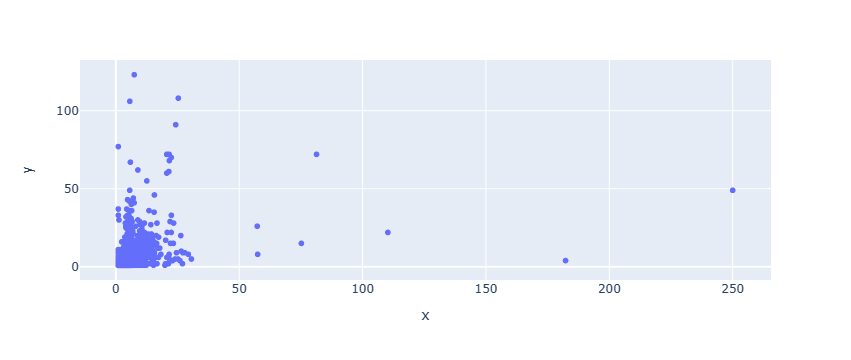

In [295]:
px.scatter(x = y.cpu().detach().numpy(), y = t.cpu().detach().numpy())

### 2.1.3. Predicting

In [373]:
%%time

pred_task1 = {}

for i, (topic_id, row) in enumerate(topics_only_target.iterrows()):
    if not row.has_content:
        pred_task1[topic_id] = 0
    else:
        text = dr_topics_only_target[i].to(device).view(1, -1)
        normal = torch.Tensor(row[row.index!="has_content"].values.tolist()).to(device).view(1, -1)

        task1.eval()
        y = task1(text, normal)+1
        y = torch.clamp(y, min=1, max=250).cpu().item()
        pred_task1[topic_id] = y

pred_task1

del task1
gc.collect()

CPU times: user 357 ms, sys: 64.1 ms, total: 421 ms
Wall time: 421 ms


{2: 7.376564025878906,
 4: 7.242954254150391,
 5: 7.978084564208984,
 6: 7.446225166320801,
 19138: 10.836140632629395}

## 2.2 Task2: Which contents do each topic have?

### 2.2.1. Data Preparation

In [13]:
%%time

target_lang = list(set(target_lang) | {"en"})
positive = correlations_transform.query("t_language==c_language")
positive = positive[positive.t_language.isin(target_lang)]
positive = positive[positive.c_language.isin(target_lang)]
positive = positive[~positive.topic_id.isin(target_topics_enc)]
positive = positive[["topic_id", "content_id", "t_language"]]
positive["pair"] = 1

negative = []
for t in positive.topic_id.unique():
    res = positive[positive.topic_id==t][["content_id", "t_language"]]
    target_c_ids = lang_contentid[lang_contentid.language.isin(res.t_language)].id
    target_c_ids = set(target_c_ids) - set(res.content_id)
    c_ids = random.sample(list(target_c_ids), len(res))
    negative += [(t,c,0) for c in c_ids]
negative = pd.DataFrame(negative, columns=["topic_id", "content_id", "pair"])

data = pd.concat([positive.drop("t_language", axis=1), negative], axis=0, ignore_index=True)

X_train, X_test, y_train, y_test = tts(data[["topic_id", "content_id"]], data.pair,
                                       test_size=.1, stratify=data.pair,
                                       shuffle=True, random_state=seed)

del positive, negative, data, c_ids, target_c_ids, target_lang, lang_contentid
gc.collect()

CPU times: user 7min 33s, sys: 364 ms, total: 7min 34s
Wall time: 7min 33s


0

In [14]:
%%time

## train data
ttext, ctext, tnormal, cnormal = [], [], [], []
for i, row in X_train.iterrows():
    ttext.append(dr_topics[dr_topics_id == row.topic_id].squeeze())
    ctext.append(dr_content[dr_content_id == row.content_id].squeeze())
    tnormal.append(torch.Tensor(topics_rev[topics_rev.index==row.topic_id].values.flatten()))
    cnormal.append(torch.Tensor(content_rev[content_rev.index==row.content_id].values.flatten()))

ttext = torch.stack(tuple(ttext))
ctext = torch.stack(tuple(ctext))
tnormal = torch.stack(tuple(tnormal))
cnormal = torch.stack(tuple(cnormal))

task2_train_dataset = TensorDataset(ttext, ctext, tnormal, cnormal, torch.Tensor(y_train.values))
task2_train_loader = DataLoader(task2_train_dataset,
                                batch_size=CFG.BATCH_SIZE,
                                shuffle=True)

print("Train Loader is created!")

## test data
ttext, ctext, tnormal, cnormal = [], [], [], []
for i, row in X_test.iterrows():
    ttext.append(dr_topics[dr_topics_id == row.topic_id].squeeze())
    ctext.append(dr_content[dr_content_id == row.content_id].squeeze())
    tnormal.append(torch.Tensor(topics_rev[topics_rev.index==row.topic_id].values.flatten()))
    cnormal.append(torch.Tensor(content_rev[content_rev.index==row.content_id].values.flatten()))

ttext = torch.stack(tuple(ttext))
ctext = torch.stack(tuple(ctext))
tnormal = torch.stack(tuple(tnormal))
cnormal = torch.stack(tuple(cnormal))

task2_test_dataset = TensorDataset(ttext, ctext, tnormal, cnormal, torch.Tensor(y_test.values))
task2_test_loader = DataLoader(task2_test_dataset,
                                batch_size=CFG.BATCH_SIZE,
                                shuffle=True)

print("Test Loader is created!")

text_normal_features = topics_rev.shape[1]

del ttext, ctext, tnormal, cnormal, topics_rev, dr_topics
gc.collect()

Train Loader is created!
Test Loader is created!
CPU times: user 3h 59s, sys: 5.94 s, total: 3h 1min 5s
Wall time: 5min 45s


0

### 2.2.2. Modeling

In [305]:
%%time

class Task2(nn.Module):
    def __init__(self, text_features, topic_features, content_features):
        super(Task2, self).__init__()
        self.units_ttext = [text_features,512,256,256,64,128,32]
        self.units_ctext = [text_features,512,256,256,64,128,32]
        self.units_tnormal = [topic_features,512,256,256,64,128,32]
        self.units_cnormal = [content_features,512,256,256,64,128,32]
        self.units_concated = [self.units_ttext[-1]+self.units_tnormal[-1],128,256,256,64,32]
        
        self.ttext_l1_bn = nn.BatchNorm1d(self.units_ttext[0])
        self.ttext_l1 = nn.Linear(self.units_ttext[0], self.units_ttext[1])
        nn.init.xavier_normal_(self.ttext_l1.weight)
        self.ttext = nn.ModuleList([nn.Linear(self.units_ttext[i+1], self.units_ttext[i+2]) for i in range(len(self.units_ttext)-2)])
        self.ttext_bn = nn.ModuleList([nn.BatchNorm1d(self.units_ttext[i+1]) for i in range(len(self.units_ttext)-2)])

        self.ctext_l1_bn = nn.BatchNorm1d(self.units_ctext[0])
        self.ctext_l1 = nn.Linear(self.units_ctext[0], self.units_ctext[1])
        nn.init.xavier_normal_(self.ctext_l1.weight)
        self.ctext = nn.ModuleList([nn.Linear(self.units_ctext[i+1], self.units_ctext[i+2]) for i in range(len(self.units_ctext)-2)])
        self.ctext_bn = nn.ModuleList([nn.BatchNorm1d(self.units_ctext[i+1]) for i in range(len(self.units_ctext)-2)])

        self.tnormal_l1_bn = nn.BatchNorm1d(self.units_tnormal[0])
        self.tnormal_l1 = nn.Linear(self.units_tnormal[0], self.units_tnormal[1])
        nn.init.xavier_normal_(self.tnormal_l1.weight)
        self.tnormal = nn.ModuleList([nn.Linear(self.units_tnormal[i+1], self.units_tnormal[i+2]) for i in range(len(self.units_tnormal)-2)])
        self.tnormal_bn = nn.ModuleList([nn.BatchNorm1d(self.units_tnormal[i+1]) for i in range(len(self.units_tnormal)-2)])

        self.cnormal_l1_bn = nn.BatchNorm1d(self.units_cnormal[0])
        self.cnormal_l1 = nn.Linear(self.units_cnormal[0], self.units_cnormal[1])
        nn.init.xavier_normal_(self.cnormal_l1.weight)
        self.cnormal = nn.ModuleList([nn.Linear(self.units_cnormal[i+1], self.units_cnormal[i+2]) for i in range(len(self.units_cnormal)-2)])
        self.cnormal_bn = nn.ModuleList([nn.BatchNorm1d(self.units_cnormal[i+1]) for i in range(len(self.units_cnormal)-2)])

        self.concated_l1_bn = nn.BatchNorm1d(self.units_concated[0])
        self.concated_l1 = nn.Linear(self.units_concated[0], self.units_concated[1])
        nn.init.xavier_normal_(self.concated_l1.weight)
        self.concated = nn.ModuleList([nn.Linear(self.units_concated[i+1], self.units_concated[i+2]) for i in range(len(self.units_concated)-2)])
        self.concated_bn = nn.ModuleList([nn.BatchNorm1d(self.units_concated[i+1]) for i in range(len(self.units_concated)-2)])
        self.concated_last_layer = nn.Linear(self.units_concated[-1], 1)
        
    def forward(self, ttext, ctext, tnormal, cnormal):
        """
        topic_text_features
        """
        ttext = F.leaky_relu(self.ttext_l1(self.ttext_l1_bn(ttext)))
        for l, b in zip(self.ttext, self.ttext_bn):
            ttext = F.leaky_relu(l(b(ttext)))
        
        """
        content_text_features
        """
        ctext = F.leaky_relu(self.ctext_l1(self.ctext_l1_bn(ctext)))
        for l, b in zip(self.ctext, self.ctext_bn):
            ctext = F.leaky_relu(l(b(ctext)))
            
        """
        topic_normal_features
        """
        tnormal = F.leaky_relu(self.tnormal_l1(self.tnormal_l1_bn(tnormal)))
        for l, b in zip(self.tnormal, self.tnormal_bn):
            tnormal = F.leaky_relu(l(b(tnormal)))

        """
        content_normal_features
        """
        cnormal = F.leaky_relu(self.cnormal_l1(self.cnormal_l1_bn(cnormal)))
        for l, b in zip(self.cnormal, self.cnormal_bn):
            cnormal = F.leaky_relu(l(b(cnormal)))

        """
        concat networks
        """
        text = torch.mul(ttext, ctext)
        normal = torch.mul(tnormal, cnormal)
        x = torch.cat([text, normal], dim=1)
        x = F.leaky_relu(self.concated_l1(self.concated_l1_bn(x)))
        for l, b in zip(self.concated, self.concated_bn):
            x = F.leaky_relu(l(b(x)))
        x = F.sigmoid(self.concated_last_layer(x)).squeeze()
        return x

    
task2 = Task2(dr_content.shape[1], text_normal_features, content_rev.shape[1])
task2.to(device);

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(task2.parameters(), lr=.01)

loss_trains, loss_tests, accuracy_trains, accuracy_tests = [], [], [], []
early_stopping_count = 0

for epoch in tqdm(range(CFG.EPOCHS)):
    #"""
    #train
    #"""
    task2.train()
    preds = []
    true_values = []
    loss_train = 0
    for j, (ttext, ctext, tnormal, cnormal, t) in enumerate(task2_train_loader):
        ttext, ctext, tnormal, cnormal, t = ttext.to(device), ctext.to(device), tnormal.to(device), cnormal.to(device), t.to(device)
        y = task2(ttext, ctext, tnormal, cnormal)
        preds += y
        true_values += t
        loss = loss_func(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    loss_trains.append(loss_train)
    y = torch.stack(preds).squeeze()
    t = torch.stack(true_values).squeeze()
    accuracy_train = (torch.sum((y > CFG.THRESHOLD)==t) / y.shape[0]).item()
    accuracy_trains.append(accuracy_train)
    
    #"""
    #test
    #"""
    task2.eval()
    preds = []
    true_values = []
    loss_test = 0
    for j, (ttext, ctext, tnormal, cnormal, t) in enumerate(task2_test_loader):
        ttext, ctext, tnormal, cnormal, t = ttext.to(device), ctext.to(device), tnormal.to(device), cnormal.to(device), t.to(device)
        y = task2(ttext, ctext, tnormal, cnormal)
        preds += y
        true_values += t
        loss = loss_func(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    loss_tests.append(loss_test)
    y = torch.stack(preds).squeeze()
    t = torch.stack(true_values).squeeze()
    accuracy_test = (torch.sum((y > CFG.THRESHOLD)==t) / y.shape[0]).item()
    
    print(f"Epoch: {epoch+1}, TrainLoss: {loss_train:.4f}, TestLoss: {loss_test:.4f}, TrainAcc: {accuracy_train:.4f}, TestAcc: {accuracy_test:.4f}.")
    print(f"test y: {y.cpu().detach().numpy()}")
    
    if len(accuracy_tests) > 0:
        best_score_before = max(accuracy_tests)
    else:
        best_score_before = None
    accuracy_tests.append(accuracy_test)
    if (max(accuracy_tests) == accuracy_test) and (best_score_before != accuracy_test):
        early_stopping_count = 0
        torch.save(task2.state_dict(), "checkpoint/task2_bestmodel.pth")
    else:
        early_stopping_count += 1
    
    if early_stopping_count == CFG.EARLY_STOPPING_ROUNDS:
        best_epoch = epoch - CFG.EARLY_STOPPING_ROUNDS
        early_stopping_message =\
        f"Best Epoch: {best_epoch+1}" + f", TrainLoss: {loss_trains[best_epoch]:.4f}"\
        + f", TestLoss: {loss_tests[best_epoch]:.4f}" + f", TrainAcc: {accuracy_trains[best_epoch]:.4f}"\
        + f", TestAcc: {accuracy_tests[best_epoch]:.4f}."
        print("!!!Early Stopping !!!")
        print(early_stopping_message)
        task2.load_state_dict(torch.load("checkpoint/task2_bestmodel.pth"))
        break

  2%|▏         | 1/50 [04:09<3:23:38, 249.36s/it]

Epoch: 1, TrainLoss: 0.3307, TestLoss: 0.3249, TrainAcc: 0.8587, TestAcc: 0.8889.
test y: [8.6298752e-01 3.2537162e-02 4.2562257e-04 ... 4.4019055e-03 8.9131534e-01
 1.6999636e-04]


  4%|▍         | 2/50 [08:14<3:17:34, 246.97s/it]

Epoch: 2, TrainLoss: 0.2387, TestLoss: 0.2557, TrainAcc: 0.9073, TestAcc: 0.9204.
test y: [4.4035760e-01 2.2574842e-04 8.7726682e-01 ... 9.8456305e-01 9.8076057e-01
 7.1789086e-01]


  6%|▌         | 3/50 [11:43<2:59:49, 229.56s/it]

Epoch: 3, TrainLoss: 0.2034, TestLoss: 0.2336, TrainAcc: 0.9239, TestAcc: 0.9268.
test y: [9.4766986e-01 1.1870468e-02 9.0055174e-01 ... 8.3900937e-05 8.6636603e-04
 4.4321571e-03]


  8%|▊         | 4/50 [15:29<2:54:51, 228.07s/it]

Epoch: 4, TrainLoss: 0.1790, TestLoss: 0.1889, TrainAcc: 0.9353, TestAcc: 0.9386.
test y: [0.57709265 0.9709501  0.94070816 ... 0.04782898 0.8063627  0.        ]


 10%|█         | 5/50 [19:37<2:56:36, 235.49s/it]

Epoch: 5, TrainLoss: 0.1619, TestLoss: 0.1738, TrainAcc: 0.9420, TestAcc: 0.9423.
test y: [9.34403658e-01 1.13805145e-01 2.16319039e-03 ... 2.75242375e-04
 9.30082560e-01 2.72215082e-04]


 12%|█▏        | 6/50 [23:06<2:46:00, 226.37s/it]

Epoch: 6, TrainLoss: 0.1470, TestLoss: 0.1933, TrainAcc: 0.9481, TestAcc: 0.9431.
test y: [9.7283113e-01 2.7420151e-04 2.8407709e-03 ... 5.5592885e-04 9.8458821e-01
 3.0593455e-02]


 14%|█▍        | 7/50 [27:15<2:47:34, 233.83s/it]

Epoch: 7, TrainLoss: 0.1360, TestLoss: 0.1955, TrainAcc: 0.9524, TestAcc: 0.9443.
test y: [9.8988706e-01 9.6874732e-01 9.7602737e-01 ... 6.4054399e-04 9.5687670e-01
 9.6701294e-01]


 16%|█▌        | 8/50 [31:13<2:44:39, 235.22s/it]

Epoch: 8, TrainLoss: 0.1248, TestLoss: 0.1799, TrainAcc: 0.9574, TestAcc: 0.9507.
test y: [1.46941275e-05 3.59534472e-03 8.63620281e-01 ... 9.47809398e-01
 9.96974230e-01 2.26019110e-05]


 18%|█▊        | 9/50 [35:22<2:43:29, 239.26s/it]

Epoch: 9, TrainLoss: 0.1166, TestLoss: 0.1646, TrainAcc: 0.9598, TestAcc: 0.9514.
test y: [0.00101633 0.99152654 0.         ... 0.87070847 0.00323738 0.9934848 ]


 20%|██        | 10/50 [38:58<2:34:46, 232.16s/it]

Epoch: 10, TrainLoss: 0.1079, TestLoss: 0.1574, TrainAcc: 0.9633, TestAcc: 0.9530.
test y: [3.0886431e-06 9.8675364e-01 8.3718231e-05 ... 1.3557637e-04 9.9575788e-01
 9.8737180e-01]


 22%|██▏       | 11/50 [43:06<2:33:59, 236.91s/it]

Epoch: 11, TrainLoss: 0.1006, TestLoss: 0.1836, TrainAcc: 0.9658, TestAcc: 0.9517.
test y: [8.7228984e-01 2.6355588e-06 3.7006862e-07 ... 9.5215809e-01 9.9564725e-01
 9.5948750e-01]


 24%|██▍       | 12/50 [46:33<2:24:21, 227.93s/it]

Epoch: 12, TrainLoss: 0.0941, TestLoss: 0.1426, TrainAcc: 0.9680, TestAcc: 0.9564.
test y: [5.3175491e-01 2.9348733e-03 9.8241293e-01 ... 9.9434978e-01 9.8984756e-06
 3.7667219e-04]


 26%|██▌       | 13/50 [50:43<2:24:42, 234.67s/it]

Epoch: 13, TrainLoss: 0.0881, TestLoss: 0.1595, TrainAcc: 0.9701, TestAcc: 0.9551.
test y: [9.8962677e-01 3.9899933e-05 1.3638414e-10 ... 9.8303312e-01 9.9615258e-01
 9.8356944e-01]


 28%|██▊       | 14/50 [54:51<2:23:10, 238.64s/it]

Epoch: 14, TrainLoss: 0.0829, TestLoss: 0.1547, TrainAcc: 0.9720, TestAcc: 0.9571.
test y: [4.6389912e-05 1.5822591e-04 1.8116760e-06 ... 2.6214434e-06 1.0347565e-06
 2.3219651e-05]


 30%|███       | 15/50 [59:05<2:21:58, 243.39s/it]

Epoch: 15, TrainLoss: 0.0784, TestLoss: 0.1450, TrainAcc: 0.9736, TestAcc: 0.9574.
test y: [9.8907989e-01 9.6399397e-01 6.8461959e-05 ... 9.8546916e-01 1.1618165e-03
 9.7943157e-01]


 32%|███▏      | 16/50 [1:02:57<2:15:55, 239.86s/it]

Epoch: 16, TrainLoss: 0.0741, TestLoss: 0.1528, TrainAcc: 0.9751, TestAcc: 0.9567.
test y: [9.9746382e-01 2.5644078e-04 9.9501282e-01 ... 1.1021036e-04 1.8251133e-03
 3.9015171e-01]


 34%|███▍      | 17/50 [1:06:46<2:10:05, 236.54s/it]

Epoch: 17, TrainLoss: 0.0708, TestLoss: 0.1795, TrainAcc: 0.9763, TestAcc: 0.9571.
test y: [1.7284156e-05 5.7733999e-08 9.8340499e-01 ... 2.0117555e-03 9.9103677e-01
 9.9171716e-01]


 36%|███▌      | 18/50 [1:10:38<2:05:28, 235.25s/it]

Epoch: 18, TrainLoss: 0.0660, TestLoss: 0.1437, TrainAcc: 0.9777, TestAcc: 0.9574.
test y: [9.9524647e-01 6.2721656e-06 1.5042770e-05 ... 9.9507940e-01 9.9684525e-01
 5.8661192e-04]


 38%|███▊      | 19/50 [1:14:43<2:02:59, 238.05s/it]

Epoch: 19, TrainLoss: 0.0629, TestLoss: 0.1838, TrainAcc: 0.9790, TestAcc: 0.9542.
test y: [9.74033892e-01 9.95769143e-01 2.66804273e-04 ... 1.55122962e-03
 9.79705751e-01 1.13187205e-04]


 40%|████      | 20/50 [1:18:51<2:00:37, 241.24s/it]

Epoch: 20, TrainLoss: 0.0598, TestLoss: 0.1526, TrainAcc: 0.9800, TestAcc: 0.9590.
test y: [0.9935807  0.9713774  0.5979808  ... 0.9882858  0.99885464 0.99294347]


 42%|████▏     | 21/50 [1:22:18<1:51:36, 230.93s/it]

Epoch: 21, TrainLoss: 0.0565, TestLoss: 0.1652, TrainAcc: 0.9810, TestAcc: 0.9585.
test y: [5.5223823e-05 9.9370700e-01 9.9757892e-01 ... 5.7796149e-07 9.9803835e-01
 5.7052501e-02]


 44%|████▍     | 22/50 [1:25:51<1:45:12, 225.46s/it]

Epoch: 22, TrainLoss: 0.0546, TestLoss: 0.2097, TrainAcc: 0.9815, TestAcc: 0.9597.
test y: [1.4905126e-05 9.2274058e-01 9.9449712e-01 ... 9.8970163e-01 2.1586026e-01
 9.9762434e-01]


 46%|████▌     | 23/50 [1:29:56<1:44:05, 231.30s/it]

Epoch: 23, TrainLoss: 0.0519, TestLoss: 0.1712, TrainAcc: 0.9826, TestAcc: 0.9589.
test y: [2.2354486e-06 5.1131982e-01 9.8986512e-01 ... 9.2243284e-01 9.9904388e-01
 1.5781973e-08]


 48%|████▊     | 24/50 [1:33:57<1:41:31, 234.29s/it]

Epoch: 24, TrainLoss: 0.0500, TestLoss: 0.2097, TrainAcc: 0.9831, TestAcc: 0.9600.
test y: [2.0386384e-05 1.4096049e-04 1.3351412e-06 ... 9.7254682e-01 2.7437656e-05
 9.9330682e-01]


 50%|█████     | 25/50 [1:38:03<1:39:07, 237.92s/it]

Epoch: 25, TrainLoss: 0.0465, TestLoss: 0.2567, TrainAcc: 0.9840, TestAcc: 0.9577.
test y: [7.3809088e-06 3.2155324e-06 9.9990368e-01 ... 9.9022502e-01 2.3557909e-03
 4.7585815e-03]


 52%|█████▏    | 26/50 [1:41:46<1:33:22, 233.43s/it]

Epoch: 26, TrainLoss: 0.0453, TestLoss: 0.1860, TrainAcc: 0.9846, TestAcc: 0.9575.
test y: [1.1657879e-04 5.0446212e-01 9.9962127e-01 ... 9.9752051e-01 9.9744356e-01
 1.8350734e-01]


 54%|█████▍    | 27/50 [1:45:14<1:26:29, 225.63s/it]

Epoch: 27, TrainLoss: 0.0436, TestLoss: 0.1685, TrainAcc: 0.9851, TestAcc: 0.9595.
test y: [9.8726094e-01 6.7361473e-04 9.9989378e-01 ... 3.0473879e-05 4.6350256e-06
 2.7971831e-03]


 56%|█████▌    | 28/50 [1:49:07<1:23:34, 227.94s/it]

Epoch: 28, TrainLoss: 0.0420, TestLoss: 0.1454, TrainAcc: 0.9858, TestAcc: 0.9584.
test y: [4.8007281e-05 9.9983883e-01 9.8551381e-01 ... 4.6942523e-06 9.9134994e-01
 3.2091033e-05]


 56%|█████▌    | 28/50 [1:52:49<1:28:38, 241.76s/it]

Epoch: 29, TrainLoss: 0.0393, TestLoss: 0.1584, TrainAcc: 0.9867, TestAcc: 0.9593.
test y: [9.9987531e-01 6.8221666e-06 6.1180719e-05 ... 9.8402631e-01 5.8104365e-06
 9.9563509e-01]
!!!Early Stopping !!!
Best Epoch: 24, TrainLoss: 0.0500, TestLoss: 0.2097, TrainAcc: 0.9831, TestAcc: 0.9600.
CPU times: user 1h 45min 59s, sys: 7min 13s, total: 1h 53min 13s
Wall time: 1h 52min 49s


### 2.2.3. Predicting

In [444]:
%%time

pred_task2 = {}
task2.eval()

for i, (topic_id, row) in enumerate(topics_only_target.iterrows()):
    if pred_task1[topic_id] == 0:
        continue
        
    ttext = dr_topics_only_target[i].to(device).view(1, -1)
    tnormal = torch.Tensor(row[row.index!="has_content"].values.tolist()).to(device).view(1, -1)

    lang = row[row.index.str.startswith("language")]
    lang = lang[lang==1].index[0].split("_")[-1]
    
    target_content_or_not = content_rev[f"language_{lang}"]==1
    content_ids = target_content_or_not.index
    target_content_or_not = target_content_or_not.tolist()
    
    dataset = TensorDataset(dr_content[target_content_or_not],
                            torch.Tensor(content_rev[target_content_or_not].values))
    dataset = DataLoader(dataset, batch_size=CFG.BATCH_SIZE)
    
    preds = []
    for j, (ctext, cnormal) in enumerate(dataset):
        ctext, cnormal = ctext.to(device), cnormal.to(device)
        y = task2(ttext, ctext, tnormal, cnormal)
        preds += y 
    pred_task2[topic_id] = pd.DataFrame(
        [(k,v) for k,v in zip(content_ids, torch.stack(preds).squeeze().detach().cpu().numpy())],
        columns=["content_id", "probability"]
    ).sort_values("probability", ascending=False).head(int(pred_task1[topic_id]))
    
    print(f"finish: topic_id == {topic_id} ({lang})")
    display(pred_task2[topic_id])

finish: topic_id == 2 (bg)


,content_id,probability
3550,3550,0.999413
697,697,0.999192
5481,5481,0.999137
4600,4600,0.999068
1064,1064,0.999045
3303,3303,0.999039
3913,3913,0.998910


finish: topic_id == 4 (pt)


,content_id,probability
5022,5022,0.998926
1520,1520,0.998707
4055,4055,0.998411
10250,10250,0.998393
918,918,0.998385
5727,5727,0.998304
8154,8154,0.998197


finish: topic_id == 5 (en)


,content_id,probability
21750,21750,0.999642
52910,52910,0.999626
27597,27597,0.999611
30119,30119,0.999597
2915,2915,0.999587
58245,58245,0.999485
319,319,0.999479


finish: topic_id == 6 (bg)


,content_id,probability
2752,2752,0.998624
3825,3825,0.998213
4166,4166,0.997601
2741,2741,0.997323
5949,5949,0.996972
948,948,0.995990
2550,2550,0.995745


finish: topic_id == 19138 (en)


,content_id,probability
58861,58861,0.999825
51489,51489,0.999790
21788,21788,0.999783
10047,10047,0.999761
30628,30628,0.999723
3147,3147,0.999723
42761,42761,0.999712
10172,10172,0.999697
41186,41186,0.999684
24812,24812,0.999682


CPU times: user 1min 15s, sys: 7.1 s, total: 1min 22s
Wall time: 1min 14s


# 3. Post Processing & Submitting

In [441]:
submission = []

for k, v in pred_task2.items():
    k = t_le.inverse_transform([k])[0]
    v = c_le.inverse_transform(v.content_id)
    v = " ".join(v)
    submission.append((k,v))

submission = pd.DataFrame(submission, columns=["topic_id", "content_ids"])
submission

,topic_id,content_ids
0,t_00004da3a1b2,c_05ffc6f85603 c_013439ef5cf9 c_0943913c4d29 c...
1,t_00068291e9a4,c_08882ccc0ff7 c_02996b61e2ba c_06d5ee82c5f9 c...
2,t_00069b63a70a,c_241f6c544df2 c_57ced41211e3 c_2db525aadef2 c...
3,t_0006d41a73a8,c_04ac9ef661b4 c_066e404e23cb c_07060cab98a8 c...
4,t_4054df11a74e,c_61bac59882e0 c_5571b806ee85 c_242d7180d1a4 c...


In [443]:
submission.to_csv("submission.csv", index=False)